# Model Deep Learning MLP (PyTorch dan TensorFlow) untuk Klasifikasi

Model ini akan mengklasifikasikan "Cover_Type" menggunakan arsitektur MLP (Multi-Layer Perceptron) dengan implementasi PyTorch dan TensorFlow.

## 1. Import Library Dasar

In [10]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

## 2. Import Library PyTorch

In [11]:
# Import library PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## 3. Import Library TensorFlow

In [3]:
# Import library TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## 4. Persiapan Data

In [4]:
# Baca dataset dari URL GitHub
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/Dataset/compressed_data.csv.gz"
response = requests.get(url)
with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
    df = pd.read_csv(f)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\nSampel Dataset:")
print(df.head())
print("\nDistribusi kelas target (Cover_Type):")
print(df['Cover_Type'].value_counts())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Soil_Type1                       

## 5. Preprocessing Data

In [5]:
# Pisahkan fitur dan target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Label encoding untuk target jika diperlukan
num_classes = len(y.unique())
print(f"\nJumlah kelas unik pada target: {num_classes}")

# Preprocessing: Standard Scaling untuk normalisasi data fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data menjadi data latih dan data uji (70:30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"Ukuran data latih: {X_train.shape}, {y_train.shape}")
print(f"Ukuran data uji: {X_test.shape}, {y_test.shape}")


Jumlah kelas unik pada target: 7
Ukuran data latih: (406708, 54), (406708,)
Ukuran data uji: (174304, 54), (174304,)


## 6. Fungsi Metrik Evaluasi

In [6]:
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    # Akurasi
    accuracy = accuracy_score(y_true, y_pred)

    # Presisi, Recall, dan F1-Score per kelas dan rata-rata
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Classification report
    report = classification_report(y_true, y_pred)

    # ROC Curve dan AUC untuk klasifikasi multi-kelas (One-vs-Rest)
    # Untuk multi-class, kita menggunakan pendekatan One-vs-Rest
    n_classes = len(np.unique(y_true))

    # Prepare untuk one-hot encoding y_true
    y_true_bin = np.zeros((len(y_true), n_classes))
    for i, val in enumerate(y_true):
        y_true_bin[i, val-1] = 1  # -1 karena kelas dimulai dari 1

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Rata-rata AUC
    avg_auc = sum(roc_auc.values()) / len(roc_auc)

    print(f"\nMatriks Evaluasi untuk model {model_name}:")
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Presisi (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"AUC (rata-rata): {avg_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    return accuracy, precision, recall, f1, avg_auc, fpr, tpr, roc_auc

# Model PyTorch

## 7. PyTorch - Definisi Model

In [7]:
class MLPPyTorch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPPyTorch, self).__init__()
        # Arsitektur MLP dengan 3 hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),    # Input layer -> Hidden layer 1
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Dropout(0.2),               # Dropout untuk mencegah overfitting
            nn.Linear(128, 64),            # Hidden layer 1 -> Hidden layer 2
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Dropout(0.2),               # Dropout
            nn.Linear(64, 32),             # Hidden layer 2 -> Hidden layer 3
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Linear(32, num_classes)     # Hidden layer 3 -> Output layer
        )

    def forward(self, x):
        return self.layers(x)

## 8. PyTorch - Persiapan Data

In [8]:
# Konversi data ke tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values - 1)  # Subtrak 1 jika kelas dimulai dari 1
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values - 1)

# Buat dataset dan dataloader PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Inisialisasi model, loss function, dan optimizer
input_size = X_train.shape[1]
model_pytorch = MLPPyTorch(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

## 9. PyTorch - Fungsi Pelatihan

In [9]:
def train_pytorch_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass dan update parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return losses

## 10. PyTorch - Pelatihan dan Evaluasi

In [12]:
# Latih model PyTorch
print("\nMelatih Model PyTorch:")
pytorch_losses = train_pytorch_model(model_pytorch, train_loader, criterion, optimizer)

# Evaluasi model PyTorch
model_pytorch.eval()
with torch.no_grad():
    y_pred_raw = model_pytorch(X_test_tensor)
    _, y_pred_pytorch = torch.max(y_pred_raw, 1)
    y_pred_pytorch = y_pred_pytorch.numpy()
    # Konversi probabilitas untuk ROC curve
    y_pred_proba_pytorch = torch.softmax(y_pred_raw, dim=1).numpy()

# Kembalikan prediksi ke skala asli
y_pred_pytorch_original = y_pred_pytorch + 1

# Evaluasi model PyTorch
print("\n--- HASIL EVALUASI MODEL PYTORCH ---")
acc_pytorch, prec_pytorch, rec_pytorch, f1_pytorch, auc_pytorch, fpr_pytorch, tpr_pytorch, roc_auc_pytorch = calculate_metrics(
    y_test.values, y_pred_pytorch_original, y_pred_proba_pytorch, "PyTorch"
)


Melatih Model PyTorch:
Epoch [5/30], Loss: 0.4606
Epoch [10/30], Loss: 0.4283
Epoch [15/30], Loss: 0.4113
Epoch [20/30], Loss: 0.4005
Epoch [25/30], Loss: 0.3935
Epoch [30/30], Loss: 0.3885

--- HASIL EVALUASI MODEL PYTORCH ---

Matriks Evaluasi untuk model PyTorch:
Akurasi: 0.8749
Presisi (weighted): 0.8745
Recall (weighted): 0.8749
F1-Score (weighted): 0.8741
AUC (rata-rata): 0.9865

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.86      0.87     63552
           2       0.89      0.91      0.90     84991
           3       0.84      0.87      0.85     10726
           4       0.88      0.59      0.71       824
           5       0.74      0.52      0.61      2848
           6       0.71      0.74      0.73      5210
           7       0.87      0.89      0.88      6153

    accuracy                           0.87    174304
   macro avg       0.83      0.77      0.79    174304
weighted avg       0.87      0.87      0.87  

## 11. PyTorch - Visualisasi Hasil

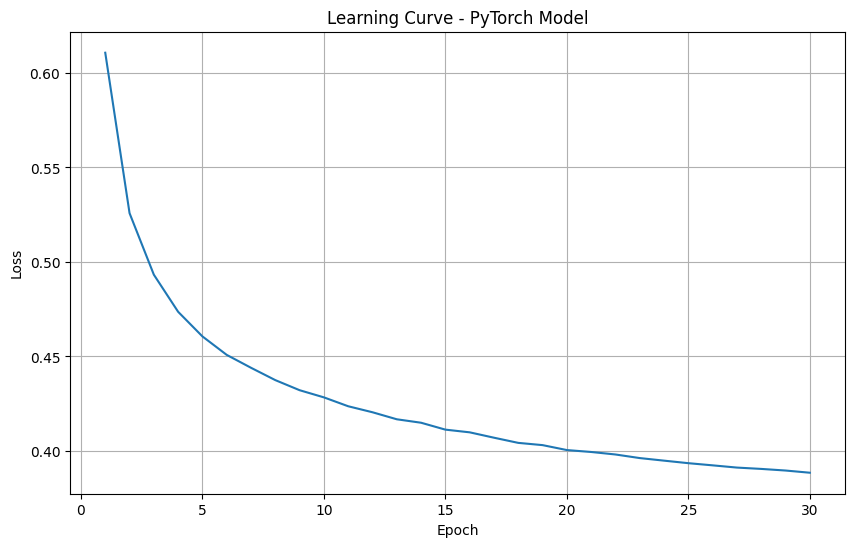

In [13]:
# Plot learning curve untuk model PyTorch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pytorch_losses) + 1), pytorch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - PyTorch Model')
plt.grid(True)
plt.show()

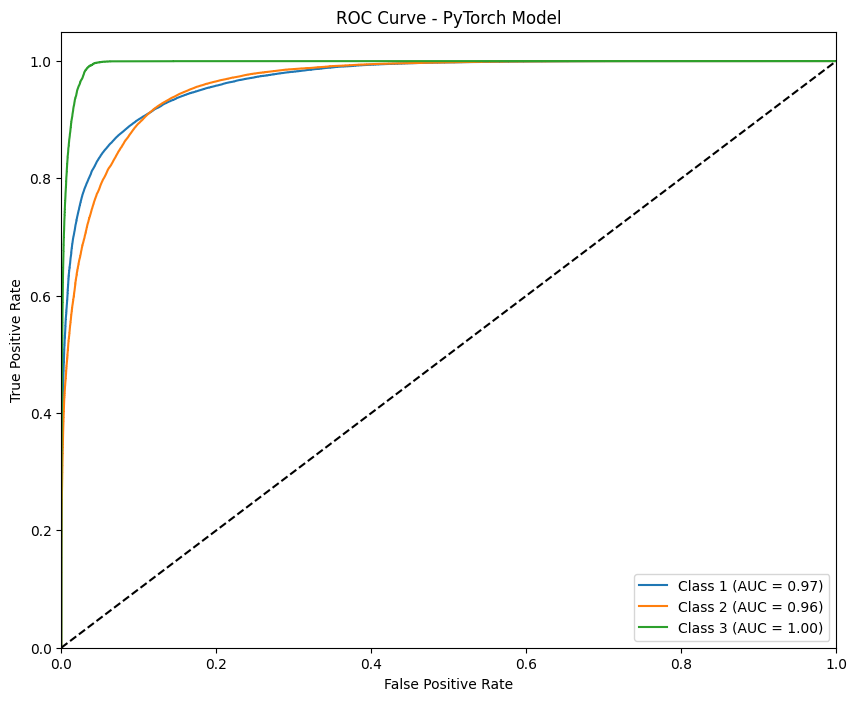

In [14]:
# Plot ROC Curve untuk model PyTorch
plt.figure(figsize=(10, 8))
selected_classes = min(3, num_classes)  # Ambil maksimal 3 kelas saja agar tidak terlalu padat
for i in range(selected_classes):
    plt.plot(fpr_pytorch[i], tpr_pytorch[i],
             label=f'Class {i+1} (AUC = {roc_auc_pytorch[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch Model')
plt.legend(loc="lower right")
plt.show()

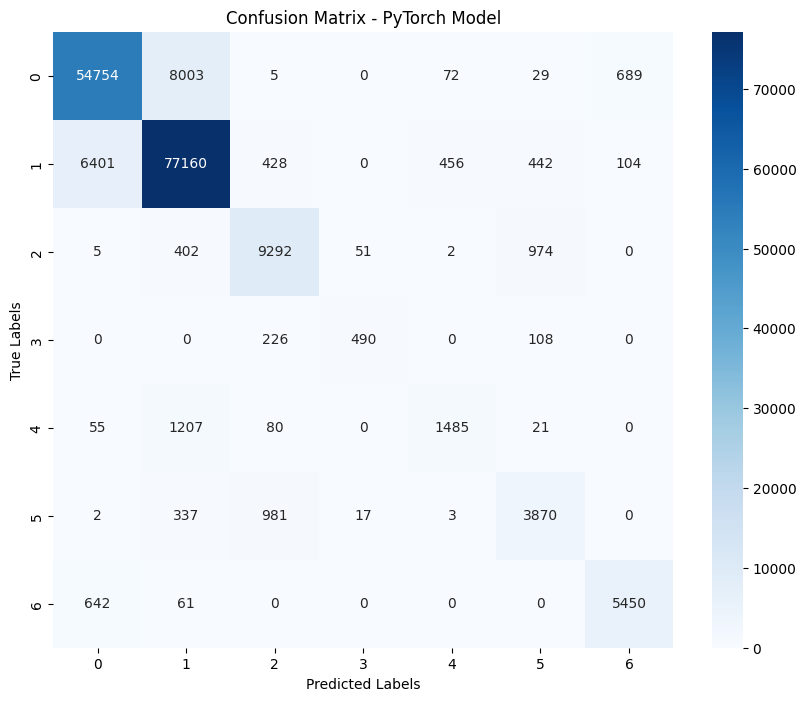

In [15]:
# Confusion Matrix untuk PyTorch
plt.figure(figsize=(10, 8))
cm_pytorch = confusion_matrix(y_test.values, y_pred_pytorch_original)
sns.heatmap(cm_pytorch, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - PyTorch Model')
plt.show()

# Model TensorFlow

## 12. TensorFlow - Definisi Model

In [16]:
# Konversi target ke categorical untuk TensorFlow
y_train_cat = to_categorical(y_train.values - 1, num_classes=num_classes)
y_test_cat = to_categorical(y_test.values - 1, num_classes=num_classes)

def create_tensorflow_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Inisialisasi model TensorFlow
model_tensorflow = create_tensorflow_model(X_train.shape[1], num_classes)

# Ringkasan model
print("\nRingkasan Model TensorFlow:")
model_tensorflow.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Ringkasan Model TensorFlow:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           7,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,607 (68.78 KB)

 Trainable params: 17,607 (68.78 KB)

 Non-trainable params: 0 (0.00 B)

## 13. TensorFlow - Pelatihan

In [17]:
# Latih model TensorFlow
print("\nMelatih Model TensorFlow:")
history = model_tensorflow.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Melatih Model TensorFlow:
Epoch 1/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6976 - loss: 0.7166 - val_accuracy: 0.7754 - val_loss: 0.5204
Epoch 2/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.7670 - loss: 0.5440 - val_accuracy: 0.7989 - val_loss: 0.4775
Epoch 3/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7827 - loss: 0.5093 - val_accuracy: 0.8126 - val_loss: 0.4455
Epoch 4/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7914 - loss: 0.4871 - val_accuracy: 0.8211 - val_loss: 0.4259
Epoch 5/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7993 - loss: 0.4739 - val_accuracy: 0.8308 - val_loss: 0.4089
Epoch 6/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8034 - loss: 0.4628 - val_accuracy: 0.8315 - val_loss: 0.4060
Epoch 7/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8091 - loss: 0.4516 - val_accuracy: 0.8369 - val_loss: 0.3923
Epoch 8/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step -

## 14. TensorFlow - Evaluasi

In [18]:
# Evaluasi model TensorFlow
y_pred_proba_tensorflow = model_tensorflow.predict(X_test)
y_pred_tensorflow = np.argmax(y_pred_proba_tensorflow, axis=1) + 1  # +1 untuk menyesuaikan kembali ke label asli

# Evaluasi hasil TensorFlow
print("\n--- HASIL EVALUASI MODEL TENSORFLOW ---")
acc_tf, prec_tf, rec_tf, f1_tf, auc_tf, fpr_tf, tpr_tf, roc_auc_tf = calculate_metrics(
    y_test.values, y_pred_tensorflow, y_pred_proba_tensorflow, "TensorFlow"
)

5447/5447 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

--- HASIL EVALUASI MODEL TENSORFLOW ---

Matriks Evaluasi untuk model TensorFlow:
Akurasi: 0.8716
Presisi (weighted): 0.8713
Recall (weighted): 0.8716
F1-Score (weighted): 0.8707
AUC (rata-rata): 0.9859

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.86      0.87     63552
           2       0.88      0.91      0.89     84991
           3       0.84      0.85      0.85     10726
           4       0.84      0.60      0.70       824
           5       0.76      0.52      0.62      2848
           6       0.71      0.73      0.72      5210
           7       0.93      0.82      0.87      6153

    accuracy                           0.87    174304
   macro avg       0.83      0.76      0.79    174304
weighted avg       0.87      0.87      0.87    174304



## 15. TensorFlow - Visualisasi Hasil

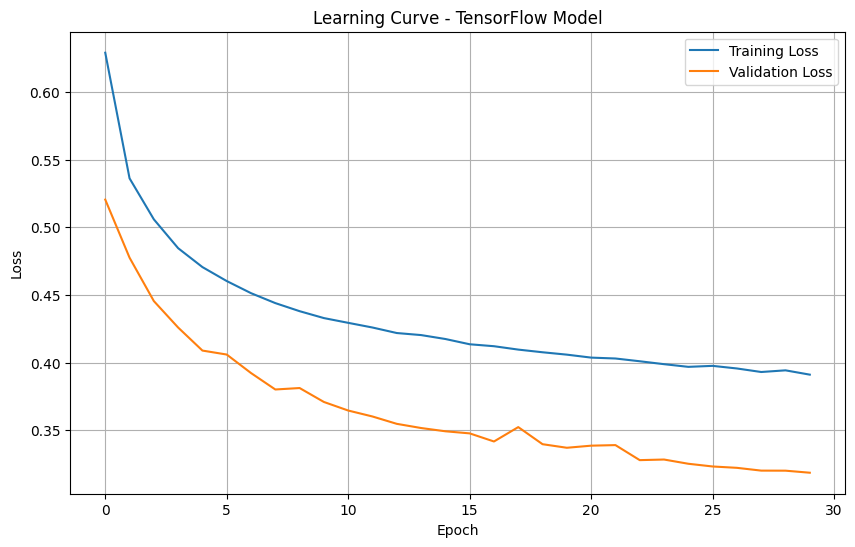

In [19]:
# Plot learning curve untuk model TensorFlow
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - TensorFlow Model')
plt.legend()
plt.grid(True)
plt.show()

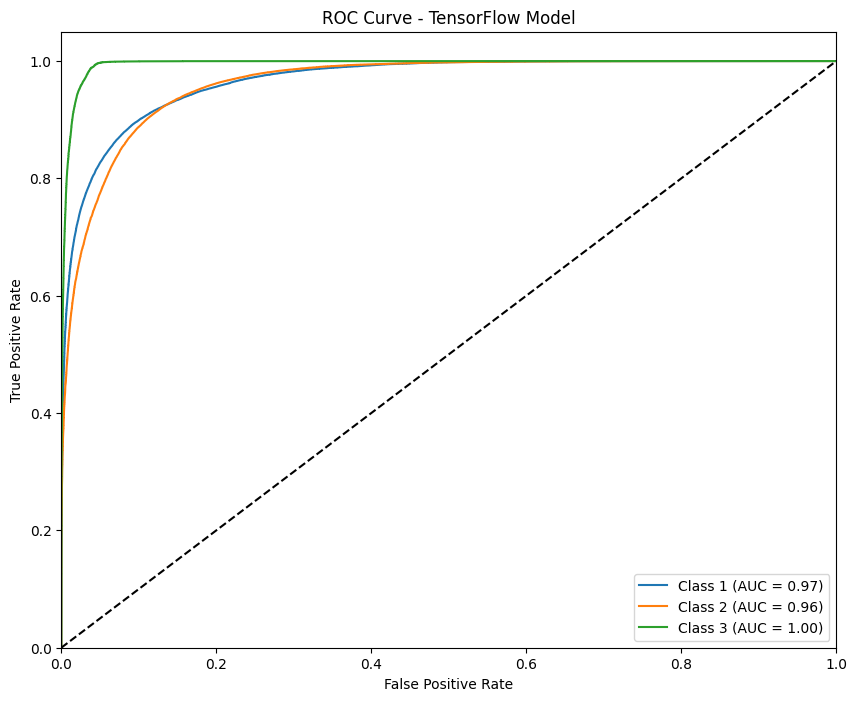

In [20]:
# Plot ROC Curve untuk model TensorFlow
plt.figure(figsize=(10, 8))
selected_classes = min(3, num_classes)  # Ambil maksimal 3 kelas saja agar tidak terlalu padat
for i in range(selected_classes):
    plt.plot(fpr_tf[i], tpr_tf[i],
             label=f'Class {i+1} (AUC = {roc_auc_tf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow Model')
plt.legend(loc="lower right")
plt.show()

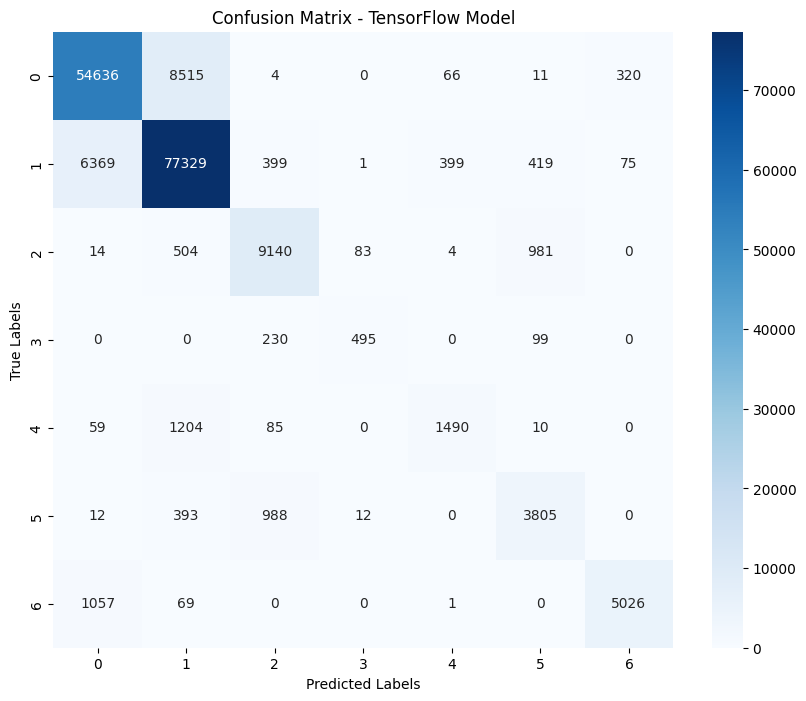

In [21]:
# Confusion Matrix untuk TensorFlow
plt.figure(figsize=(10, 8))
cm_tf = confusion_matrix(y_test.values, y_pred_tensorflow)
sns.heatmap(cm_tf, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - TensorFlow Model')
plt.show()

# Perbandingan Model

In [22]:
# Tampilkan perbandingan metrik dari kedua model
metrics_comparison = pd.DataFrame({
    'Metrik': ['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'AUC'],
    'PyTorch': [acc_pytorch, prec_pytorch, rec_pytorch, f1_pytorch, auc_pytorch],
    'TensorFlow': [acc_tf, prec_tf, rec_tf, f1_tf, auc_tf]
})

print("\nPerbandingan Metrik:")
print(metrics_comparison)


Perbandingan Metrik:
     Metrik   PyTorch  TensorFlow
0   Akurasi  0.874914    0.871586
1   Presisi  0.874500    0.871270
2    Recall  0.874914    0.871586
3  F1-Score  0.874130    0.870678
4       AUC  0.986509    0.985863


## 1. Matriks Evaluasi

### Mean Squared Error (MSE)
MSE = (1/n) * Σ(y_i - ŷ_i)²

Dimana:
- n adalah jumlah sampel
- y_i adalah nilai sebenarnya
- ŷ_i adalah nilai prediksi

MSE mengukur rata-rata kesalahan kuadrat antara nilai prediksi dan nilai sebenarnya. Semakin rendah nilai MSE, semakin baik model dalam memprediksi.

### Root Mean Squared Error (RMSE)
RMSE = √MSE = √[(1/n) * Σ(y_i - ŷ_i)²]

RMSE adalah akar kuadrat dari MSE, yang memberikan nilai kesalahan dalam satuan yang sama dengan variabel target. RMSE lebih mudah diinterpretasikan karena satuannya sama dengan variabel yang diprediksi.

### Coefficient of Determination (R²)
R² = 1 - [Σ(y_i - ŷ_i)² / Σ(y_i - ȳ)²]

Dimana:
- y_i adalah nilai sebenarnya
- ŷ_i adalah nilai prediksi
- ȳ adalah rata-rata nilai sebenarnya

R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen.
Nilai R² berkisar antara 0 dan 1:
- R² = 1: Model menjelaskan semua variabilitas data
- R² = 0: Model tidak menjelaskan variabilitas data
- R² < 0: Model lebih buruk daripada garis horizontal

## 2. Penjelasan Persamaan Matematika yang Digunakan

### Fungsi Aktivasi ReLU (Rectified Linear Unit)
ReLU(x) = max(0, x)

ReLU adalah fungsi aktivasi yang mengembalikan x jika x positif dan 0 jika x negatif. ReLU membantu mengatasi masalah vanishing gradient pada jaringan neural yang dalam.

### Forward Pass dalam MLP
a. Input Layer: z¹ = x
b. Hidden Layer: z^(l+1) = σ(W^l * z^l + b^l)
c. Output Layer: ŷ = W^L * z^L + b^L

Dimana:
- σ adalah fungsi aktivasi (ReLU dalam kasus ini)
- W^l adalah matriks bobot pada layer l
- b^l adalah vektor bias pada layer l
- z^l adalah output dari layer l
- L adalah jumlah total layer

### Backpropagation dengan Gradient Descent
W^l = W^l - η * ∂L/∂W^l
b^l = b^l - η * ∂L/∂b^l

Dimana:
- η adalah learning rate
- ∂L/∂W^l adalah gradien loss terhadap bobot
- ∂L/∂b^l adalah gradien loss terhadap bias

### Dropout untuk Regularisasi
P(z_i^l) = {
  0 dengan probabilitas p
  z_i^l/(1-p) dengan probabilitas (1-p)
}

Dropout secara acak menetapkan beberapa neuron menjadi 0 selama pelatihan, yang membantu mencegah co-adaptation dan mengurangi overfitting.

## 3. Implementasi

Kedua model (PyTorch dan TensorFlow) diimplementasikan dengan arsitektur yang sama untuk memungkinkan perbandingan yang adil. Keduanya menggunakan:
- Adam optimizer dengan learning rate 0.001
- MSE sebagai fungsi loss
- Batch size 32
- 50 epoch untuk pelatihan

## 4. Proses Evaluasi

1. Dataset dibagi menjadi data latih (70%) dan data uji (30%)
2. Model dilatih pada data latih
3. Prediksi dilakukan pada data uji
4. Metrik evaluasi (RMSE, MSE, R²) dihitung berdasarkan nilai prediksi dan nilai sebenarnya
5. Hasil visualisasi berupa scatter plot dan learning curve untuk menganalisis performa model